<a href="https://colab.research.google.com/github/ZiadAlagroudy/Binary-Classification-for-Leukemia-using-pretrained-models/blob/main/Binary_Classification_using_VGG_16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import glob
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import warnings
warnings.filterwarnings('ignore')


Loading all the photos from deffierent paths

In [ ]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [ ]:
all_0 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all"
all_1 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all"
all_2 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem"
path_val ='/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data'
val_labels = pd.read_csv('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_data = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
test_list = get_path_image(test_data)

test_dict = {"x_col":test_list}

test_df = pd.DataFrame(test_dict)

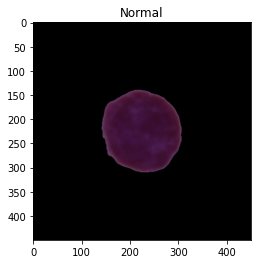

In [ ]:
a_image_fnames = os.listdir(hem_1)
cancer_img = cv2.imread(os.path.join(hem_1,a_image_fnames[100]))
plt.imshow(cancer_img)
plt.title('Normal')
plt.show()

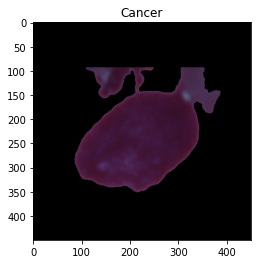

In [ ]:
h_image_fnames = os.listdir(all_2)
h_img = cv2.imread(os.path.join(all_2,h_image_fnames[5]))
plt.imshow(h_img)
plt.title('Cancer')
plt.show()

In [ ]:
cancer_lst = []

for i in [all_0,all_1,all_2]:
    paths = get_path_image(i)
    cancer_lst.extend(paths)
print('No. of cancer images:', len(cancer_lst))

normal_lst = []
for i in [hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    normal_lst.extend(paths)
print('No. of normal images:', len(normal_lst))

No. of cancer images: 7272
No. of normal images: 3389


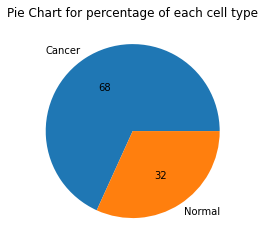

In [ ]:
cancer_dict = {"x_col":cancer_lst, "y_col":[np.nan for x in range(len(cancer_lst))]}
cancer_dict["y_col"] = "ALL"

normal_dict = {"x_col":normal_lst, "y_col":[np.nan for x in range(len(normal_lst))]}
normal_dict["y_col"] = "HEM"


cancer_df = pd.DataFrame(cancer_dict)
normal_df = pd.DataFrame(normal_dict)

train_df = cancer_df.append(normal_df, ignore_index=True)

plt.pie([len(cancer_lst),len(normal_lst)],labels=["Cancer","Normal"],autopct='%.f')
plt.title('Pie Chart for percentage of each cell type')
plt.show()

In [ ]:
#Reading the validation data
validation_list = get_path_image(path_val)
print(path_val)

##Convert the list to a dictionary. The labels are stored in the val_labels
#3So we create a dictionary with x as the file name and y as the labels
##The labels are having 0's and 1's.
##0 means normal and 1 means cancer - ALL

validation_dict = {"x_col":validation_list ,"y_col":val_labels["labels"]}

validation_df = pd.DataFrame(validation_dict)

validation_df["y_col"].replace(to_replace = [1,0], value = ["ALL","HEM"], inplace = True)

/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data


In [ ]:
test_data = '../input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
test_list = get_path_image(test_data)

test_dict = {"x_col":test_list}

test_df = pd.DataFrame(test_dict)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (450, 450),
                 
                  batch_size = 32,
                  color_mode = "rgb",
                  class_mode = "binary"
)

Found 10661 validated image filenames belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = val_datagen.flow_from_dataframe(
                  validation_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (450, 450),                  
                  batch_size = 32,
                  color_mode = "rgb",
                  class_mode = "binary")

Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255 )
test_generator = test_datagen.flow_from_dataframe(
                  test_df,
                  x_col = "x_col",
                  target_size = (450, 450),
                  color_mode = "rgb",
                  class_mode = None,
                  shuffle = False
)

Found 2586 validated image filenames.


**MobileNet**

In [ ]:
MN=MobileNet(input_shape=(450,450,3),include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
for layers in MN.layers:
    layers.trainable=False

In [ ]:
out= Flatten()(MN.output)
out=Dense(2,activation='sigmoid')(out)

In [ ]:
model=Model(inputs=MN.input,outputs=out)

**Sequential**

In [ ]:
model =  Sequential(
    [
        Conv2D(filters = 16,kernel_size=(3,3),activation='relu',input_shape=(450,450,3)),
        Conv2D(filters = 36,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters = 64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters = 128,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(rate=0.25),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(rate=0.25),
        Dense(2 , activation= 'sigmoid')
    ], name="Complex"
)

In [ ]:

es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=8,verbose=1,mode='max')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="mymodel.h5",save_best_only=True,verbose=1,mode='max') 
cd=[es,mc] 

In [ ]:
model.compile(
    loss=binary_crossentropy,
    metrics=['accuracy'],
    optimizer=Adam(0.001)

)

**VGG16**

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(450, 450, 3))

2022-12-20 21:15:02.205863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:15:02.376682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:15:02.377575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:15:02.379539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_model.layers[:15]:
    layer.trainable = False
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(1072, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.8)(x) # Dropout layer to reduce overfitting
x = Dense(1, activation='sigmoid')(x)
x = Dropout(0.3)(x) # Dropout layer to reduce overfitting
transfer_model = Model(inputs=vgg_model.input, outputs=x)
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_4 True
20 dense_13 True
21 dense_14 True
22 dropout_3 True
23 dense_15 True
24 dropout_4 True


In [ ]:
for layer in vgg_model.layers[:7]:
    layer.trainable = False
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dense(420, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=x)
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_7 True
20 dense_26 True
21 dense_27 True
22 dense_28 True
23 dense_29 True
24 dense_30 True
25 dense_31 True
26 dense_32 True
27 dense_33 True
28 dropout_7 True
29 dense_34 True


In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=3, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
ck=[lr_reduce,checkpoint]

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
transfer_model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history = transfer_model.fit_generator(train_generator,epochs=30,verbose=1, validation_data=(validation_generator), callbacks=ck)